# Fraud Detection Project


## Data Exploration
This dataset contains credit card transactions from European cardholders over two days in September 2013. Things to note:
- Features `V1` to `V28` are PCA-transformed, so their exact meanings are unknown.
- `Amount` is the transaction value, and `Time` represents the seconds elapsed since the first transaction.


In [51]:
# Import necessary libraries

# Basic Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv("creditcard.csv")

# Dataset summary
print(f"Dataset contains {data.shape[0]} rows and {data.shape[1]} columns.")
print("Columns in the dataset:")
print(data.columns)

# Display the first few rows
data.head()

Dataset contains 284807 rows and 31 columns.
Columns in the dataset:
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Explore the Target Variable (`Class`)
The `Class` column represents whether a transaction is fraudulent:
- **0**: Non-Fraudulent
- **1**: Fraudulent

Since the dataset is highly imbalanced, we will visualize the class distribution to confirm this imbalance.


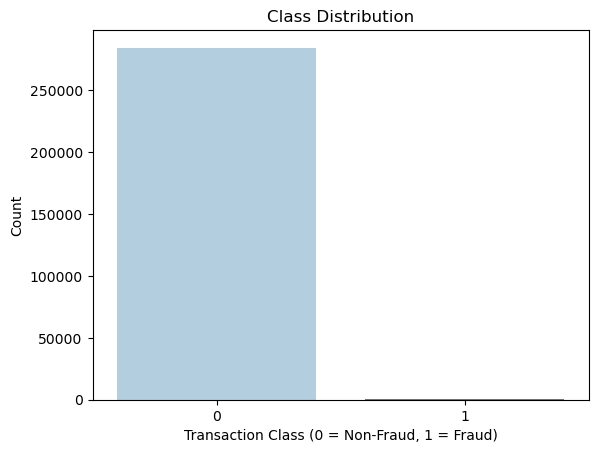

Total transactions: 284807
Fraudulent transactions: 492 (0.173%)
Non-Fraudulent transactions: 284315 (99.827%)


In [52]:
# Visualize the target variable with updated syntax
sns.countplot(x='Class', hue='Class', data=data, palette='Blues', dodge=False, legend=False)
plt.title("Class Distribution")
plt.xlabel("Transaction Class (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Count")
plt.show()

# Calculate counts and percentages
fraud_count = data['Class'].sum()  # Total fraudulent transactions (Class = 1)
non_fraud_count = len(data) - fraud_count  # Total non-fraudulent transactions (Class = 0)
total_count = len(data)
fraud_percentage = (fraud_count / total_count) * 100

# Print the counts and percentages
print(f"Total transactions: {total_count}")
print(f"Fraudulent transactions: {fraud_count} ({fraud_percentage:.3f}%)")
print(f"Non-Fraudulent transactions: {non_fraud_count} ({100 - fraud_percentage:.3f}%)")


Only 0.173% of transactions are fraudulent. This indicates that the data is highly unbalanced with respect to the target variable Class.

## Analyze Key Features
The dataset includes:
- PCA-transformed features (`V1` to `V28`): Numerical representations of the original features, transformed for privacy.
- `Amount`: Transaction value.
- `Time`: Seconds elapsed since the first transaction.

### Analysis Goals:
1. Identify patterns in fraud using `Amount` and `Time`.
2. Visualize how fraud cases differ from non-fraud cases.

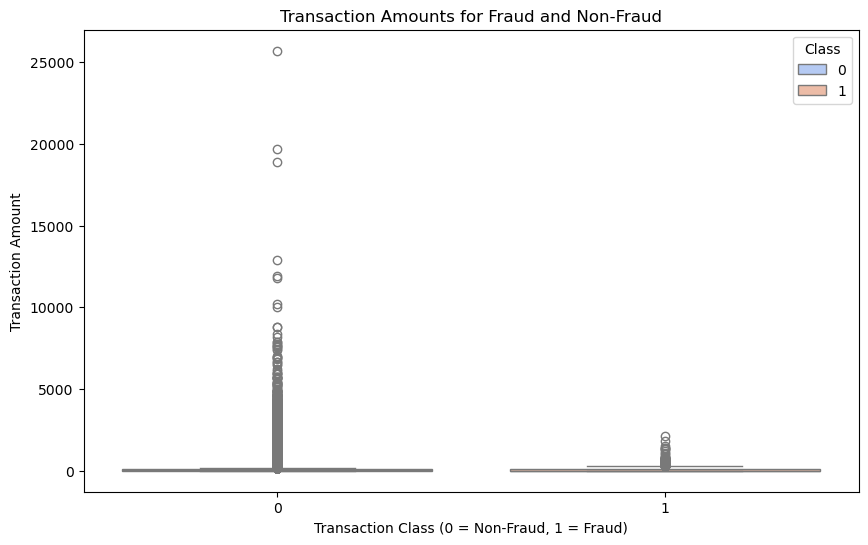

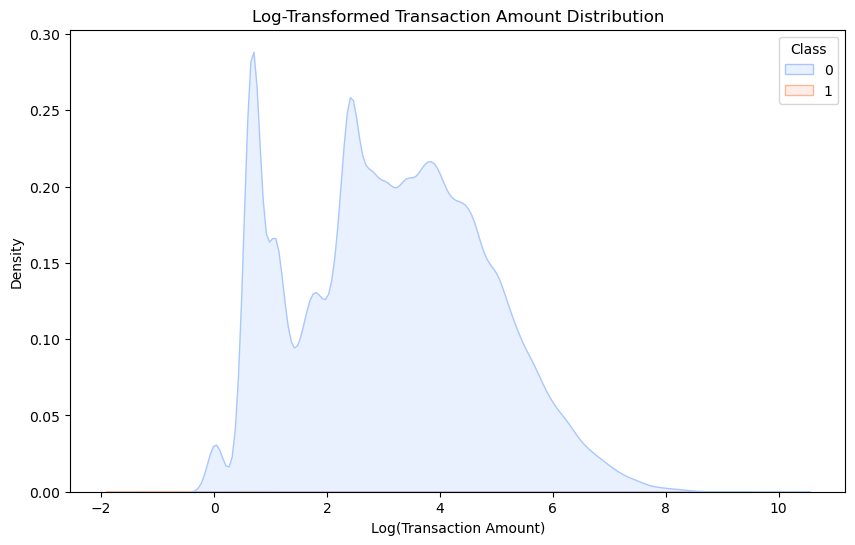

In [53]:
# Boxplot for transaction amounts
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Amount', data=data, hue='Class', palette='coolwarm')
plt.title("Transaction Amounts for Fraud and Non-Fraud")
plt.xlabel("Transaction Class (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Transaction Amount")
plt.show()

# Log-transform the 'Amount' column to handle skewness
data['Log_Amount'] = np.log1p(data['Amount'])

# KDE plot for log-transformed amounts
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x='Log_Amount', hue='Class', fill=True, palette='coolwarm')
plt.title("Log-Transformed Transaction Amount Distribution")
plt.xlabel("Log(Transaction Amount)")
plt.ylabel("Density")
plt.show()

The boxplot shows that fraudulent transactions are concentrated in lower transaction amounts, while non-fraudulent transactions have a much wider range, including high-value outliers. 

The log-transformed KDE plot shows significant overlap between fraudulent and non-fraudulent transactions at lower transaction amounts, making fraud harder to distinguish in this range. However, as transaction amounts increase (higher log values), fraudulent transactions become negligible, with non-fraudulent transactions dominating mid-to-high values, reflecting legitimate behavior in larger purchases.

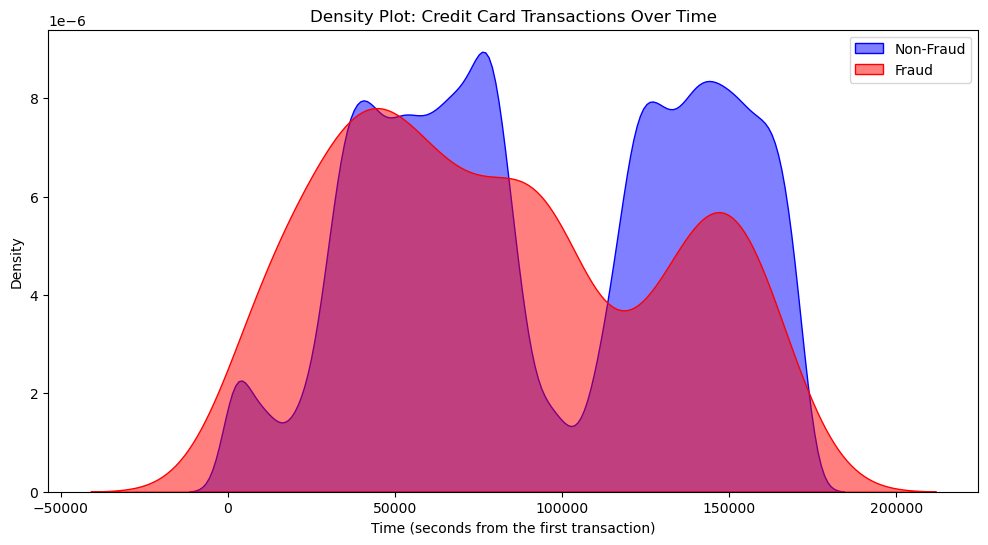

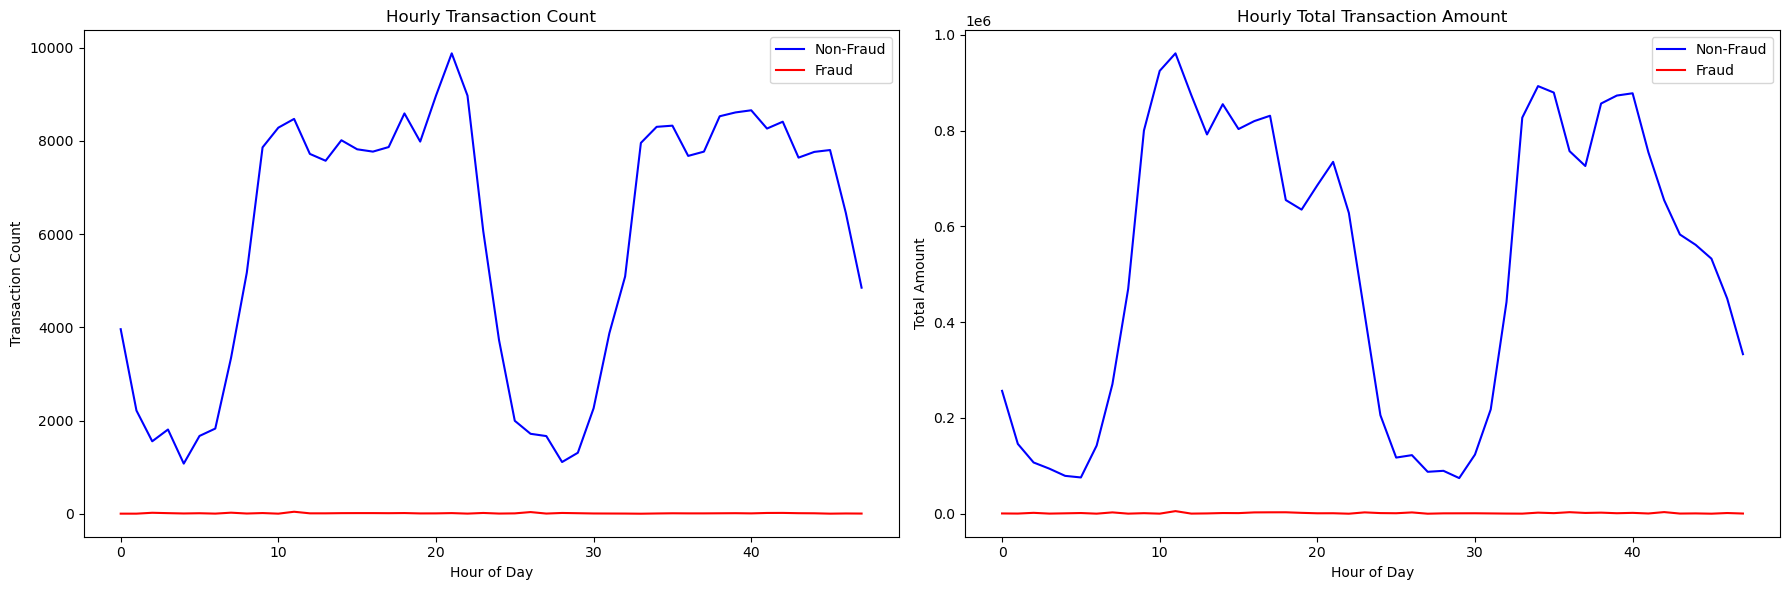

In [54]:
# Split data by class
fraudulent = data[data['Class'] == 1]
non_fraudulent = data[data['Class'] == 0]

# Density plot for time distribution
plt.figure(figsize=(12, 6))
sns.kdeplot(non_fraudulent['Time'], label='Non-Fraud', fill=True, color='blue', alpha=0.5)
sns.kdeplot(fraudulent['Time'], label='Fraud', fill=True, color='red', alpha=0.5)
plt.title("Density Plot: Credit Card Transactions Over Time")
plt.xlabel("Time (seconds from the first transaction)")
plt.ylabel("Density")
plt.legend()
plt.show()

# Add 'Hour' column
data['Hour'] = data['Time'].apply(lambda x: np.floor(x / 3600))

# Aggregate transaction metrics by hour and class
hourly_stats = data.groupby(['Hour', 'Class']).agg({
    'Amount': ['sum', 'mean', 'count', 'max', 'min', 'median']
}).reset_index()
hourly_stats.columns = ['Hour', 'Class', 'Total_Amount', 'Average_Amount', 'Transaction_Count', 'Max_Amount', 'Min_Amount', 'Median_Amount']

# Split into fraudulent and non-fraudulent
fraud_hourly = hourly_stats[hourly_stats['Class'] == 1]
non_fraud_hourly = hourly_stats[hourly_stats['Class'] == 0]

# Plot transaction count and total amount
fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

sns.lineplot(ax=axs[0], x='Hour', y='Transaction_Count', data=non_fraud_hourly, label='Non-Fraud', color='blue')
sns.lineplot(ax=axs[0], x='Hour', y='Transaction_Count', data=fraud_hourly, label='Fraud', color='red')
axs[0].set_title("Hourly Transaction Count")
axs[0].set_xlabel("Hour of Day")
axs[0].set_ylabel("Transaction Count")
axs[0].legend()

sns.lineplot(ax=axs[1], x='Hour', y='Total_Amount', data=non_fraud_hourly, label='Non-Fraud', color='blue')
sns.lineplot(ax=axs[1], x='Hour', y='Total_Amount', data=fraud_hourly, label='Fraud', color='red')
axs[1].set_title("Hourly Total Transaction Amount")
axs[1].set_xlabel("Hour of Day")
axs[1].set_ylabel("Total Amount")
axs[1].legend()

plt.tight_layout()
plt.show()


Fraudulent transactions show a more even distribution across time compared to valid transactions, including during periods of low activity for real transactions, such as night time at around 1000000. This suggests that fraudsters may intentionally operate during off-peak hours to evade detection, highlighting the importance of monitoring transactions consistently across all time intervals.

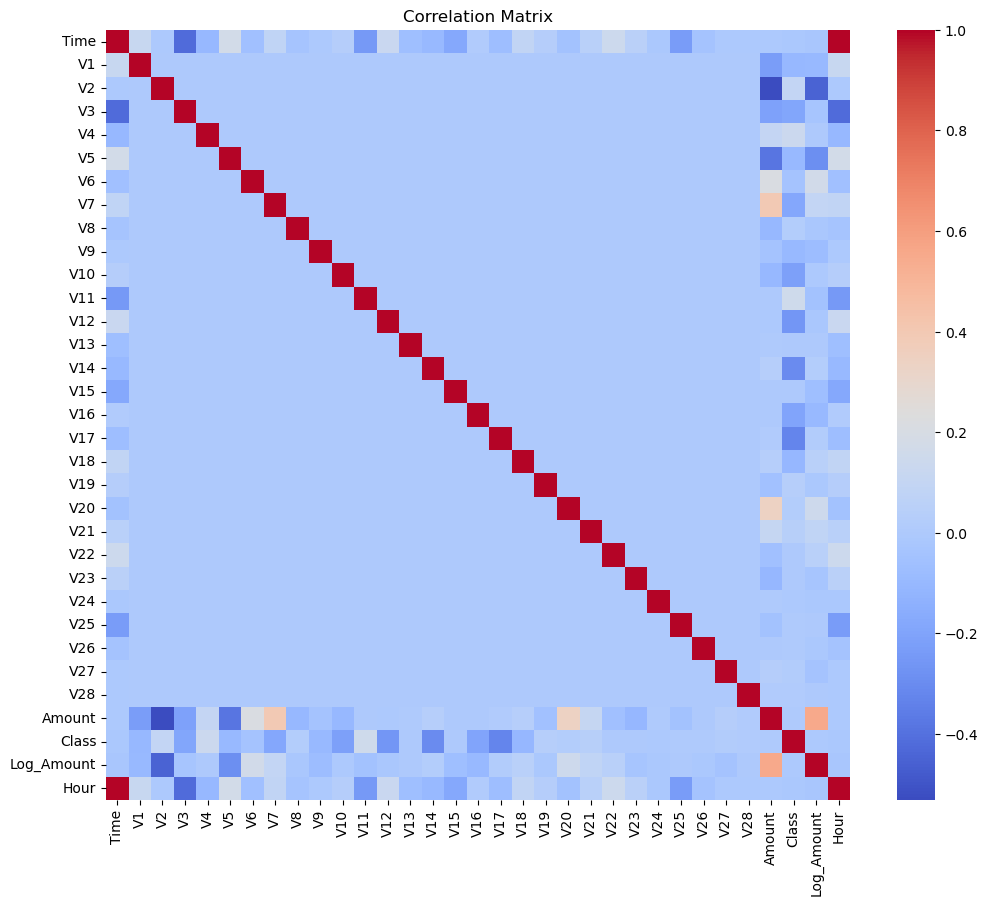

In [55]:
# Correlation matrix
correlation_matrix = data.corr()

# Plot heatmap of correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, cbar=True)
plt.title("Correlation Matrix")
plt.show()

There is no particular correlation between any of the features V1-V28. However there are other correactions with time and amount, such as an inverse correlation between time and v3, and amount and v2. 

## Feature Engineering
1. **Normalize `Amount`**: Scale the transaction amount to standardize its range.
2. **Drop `Time`**: The `Time` feature has limited predictive value based on prior analysis.
3. **Prepare Features (`X`) and Target (`y`)**: Separate input features and target variabe.


In [56]:
# Normalize the 'Amount' feature
scaler = StandardScaler()
data['Normalized_Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))

# Drop 'Amount' and 'Time'
data = data.drop(['Amount', 'Time'], axis=1)

# Create 'Off-Peak' feature
data['Off_Peak'] = data['Hour'].apply(lambda x: 1 if x < 6 or x > 22 else 0)

# Median amount flag
median_amount = data['Normalized_Amount'].median()
data['Above_Median_Amount'] = (data['Normalized_Amount'] > median_amount).astype(int)

# Drop 'Hour' for modeling purposes
data = data.drop(['Hour'], axis=1)


## Handling Class Imbalance
Since fraudulent transactions are rare, we use **SMOTE** (Synthetic Minority Oversampling Technique) to balance the dataset.
- SMOTE generates synthetic samples for the minority class (fraudulent transactions).
- This ensures the model learns to detect fraud effectively without being biased toward the majority class.


In [57]:
from imblearn.over_sampling import SMOTE

# Separate features and target
X = data.drop('Class', axis=1)
y = data['Class']

# Train-test split before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verify the new class distribution
print("Class Distribution After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Class Distribution After SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


## Training the ModelsWe are going to use multiple different models to ensure that we choose the one that best balances accuracy, precisionm, recall, and interpretability.ons.


#### Logistic Regression

In [58]:
logreg = LogisticRegression(max_iter=500, random_state=42)
logreg.fit(X_train_resampled, y_train_resampled)

# Predictions and evaluation
logreg_preds = logreg.predict(X_test)
logreg_auc = roc_auc_score(y_test, logreg_preds)
print(f"Logistic Regression AUC (after SMOTE): {logreg_auc}")

Logistic Regression AUC (after SMOTE): 0.9369069272334708


#### Random Forest Classifier

In [59]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Predictions and evaluation
rf_preds = rf.predict(X_test)
rf_auc = roc_auc_score(y_test, rf_preds)
print(f"Random Forest AUC (after SMOTE): {rf_auc}")

Random Forest AUC (after SMOTE): 0.9029381237582259


#### XGBoost

In [60]:
xgb = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_resampled, y_train_resampled)

# Predictions and evaluation
xgb_preds = xgb.predict(X_test)
xgb_auc = roc_auc_score(y_test, xgb_preds)
print(f"XGBoost AUC (after SMOTE): {xgb_auc}")

XGBoost AUC (after SMOTE): 0.928351605836482


## Model Evaluation
We evaluate the model using:
1. **Precision-Recall Curve**: This is more meaningful for imbalanced datasetes.


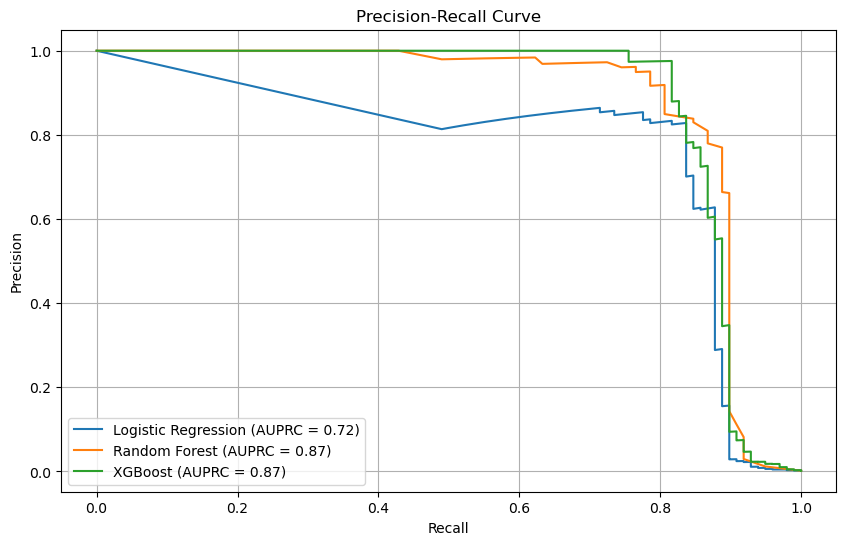

In [62]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Generate probabilities for each model
logreg_probs = logreg.predict_proba(X_test)[:, 1]
rf_probs = rf.predict_proba(X_test)[:, 1]
xgb_probs = xgb.predict_proba(X_test)[:, 1]

# Compute precision, recall, and thresholds
logreg_precision, logreg_recall, _ = precision_recall_curve(y_test, logreg_probs)
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_probs)

# Compute average precision scores
logreg_ap = average_precision_score(y_test, logreg_probs)
rf_ap = average_precision_score(y_test, rf_probs)
xgb_ap = average_precision_score(y_test, xgb_probs)

plt.figure(figsize=(10, 6))

# Plot PR curve for each model
plt.plot(logreg_recall, logreg_precision, label=f'Logistic Regression (AUPRC = {logreg_ap:.2f})')
plt.plot(rf_recall, rf_precision, label=f'Random Forest (AUPRC = {rf_ap:.2f})')
plt.plot(xgb_recall, xgb_precision, label=f'XGBoost (AUPRC = {xgb_ap:.2f})')

# Add labels and legend
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()


## Analyze Feature Importance
Analyze which PCA-transformed features (`V1` to `V28`) contribute most to the model's predictions


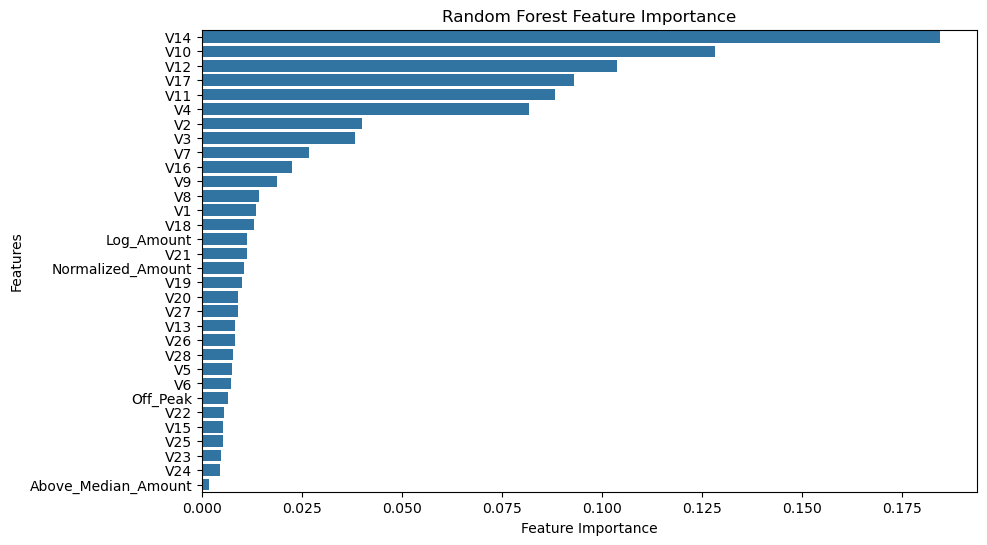

<Figure size 1000x800 with 0 Axes>

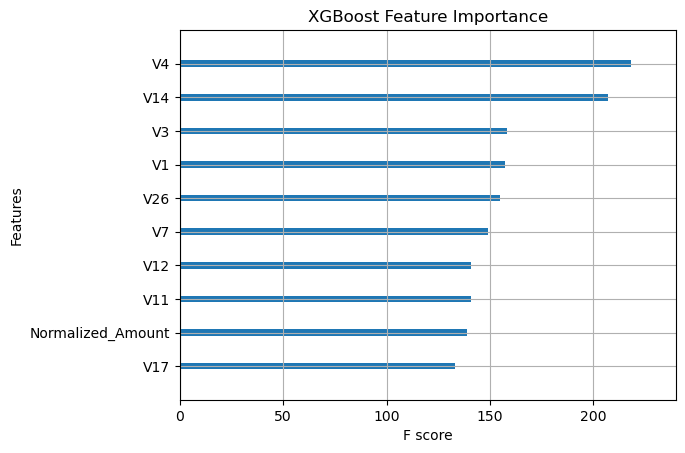

   Feature  Random_Forest   XGBoost
13     V14       0.184581  0.012724
9      V10       0.128261  0.007602
11     V12       0.103703  0.010356
16     V17       0.092982  0.055735
10     V11       0.088285  0.004324
3       V4       0.081660  0.005560
1       V2       0.040034  0.011875
2       V3       0.038294  0.030112
6       V7       0.026676  0.006176
15     V16       0.022477  0.013991


In [63]:
# Extract feature importance from Random Forest
rf_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_feature_importance)
plt.title("Random Forest Feature Importance")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

from xgboost import plot_importance

# Plot feature importance directly using XGBoost
plt.figure(figsize=(10, 8))
plot_importance(xgb, max_num_features=10, importance_type='weight', show_values=False)
plt.title("XGBoost Feature Importance")
plt.show()

# Combine the importance from both models for comparison
combined_importance = pd.DataFrame({
    'Feature': rf_feature_importance['Feature'],
    'Random_Forest': rf_feature_importance['Importance'],
    'XGBoost': xgb.feature_importances_
}).sort_values(by='Random_Forest', ascending=False)

# Display top 10 features
print(combined_importance.head(10))

## Conclusion

This project developed an effective fraud detection system using a highly imbalanced credit card transaction dataset. By exploring the data, we identified key patterns in fraudulent behavior and used PCA-transformed features as primary predictors. SMOTE was applied to balance the dataset, enhancing model performance. Logistic Regression served as a baseline (AUPRC: 0.72, AUC: 0.93), while Random Forest and XGBoost achieved superior results (AUPRC: 0.87, AUC: 0.92), leveraging feature interactions and non-linear patterns. Feature importance analysis highlighted V14, V10, and V4 as critical predictors, with engineered features like Normalized_Amount adding context.

These findings demonstrate the value of advanced machine learning techniques in fraud detection. Models like Random Forest and XGBoost are suitable for real-time deployment and provide actionable insights into fraudulent behavior. This project emphasizes the importance of continuously adapting fraud detection systems to evolving transaction patterns, improving financial security and consumer trust.